# Data Exploration and preprocessing

## Dealing with Missing Values

In [364]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

raw_data = pd.read_csv("./data.csv",na_values=['?','Unknown/Invalid'],low_memory=False)

def missing_data_info(df):
    # some stats about the missing values in the data 
    null_counts = df.isnull().sum()
    null_cols = null_counts[null_counts > 0].index.tolist()

    print("*************************Missing Data info***************************************")
    print("Length of All data : ",len(df ))
    print("Length of data with non nulls : ",len(df.dropna()))
    print("Number of columns with at least one null value:",len(null_cols))
    if len(null_cols) > 0:
        print("Column names and their number of missing values:")
        adf = df[null_cols]
        adf_null_counts = adf.isnull().sum()
        print(adf_null_counts)
    print("****************************************************************")
    
missing_data_info(raw_data)


*************************Missing Data info***************************************
Length of All data :  101766
Length of data with non nulls :  1043
Number of columns with at least one null value: 8
Column names and their number of missing values:
race                  2273
gender                   3
weight               98569
payer_code           40256
medical_specialty    49949
diag_1                  21
diag_2                 358
diag_3                1423
dtype: int64
****************************************************************


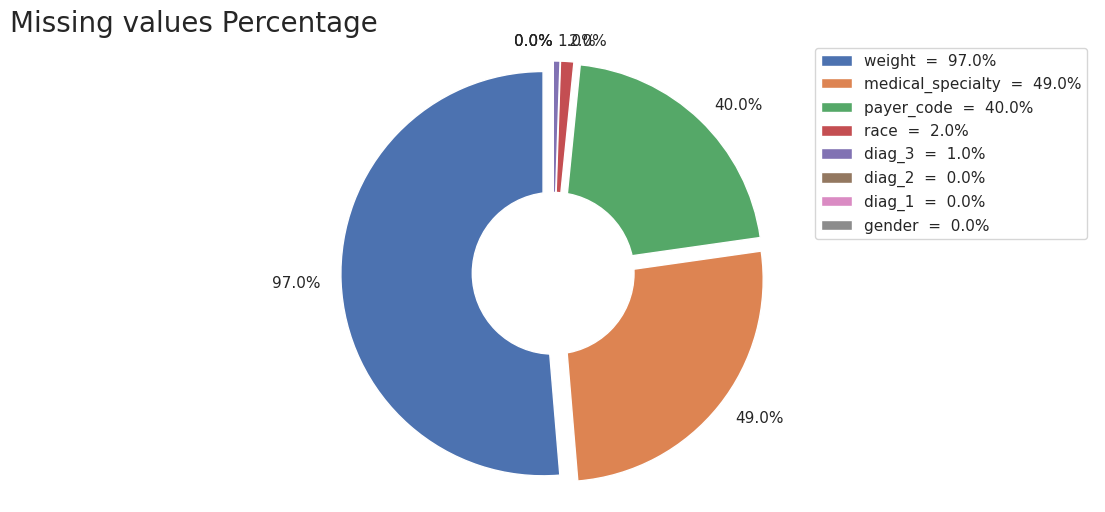

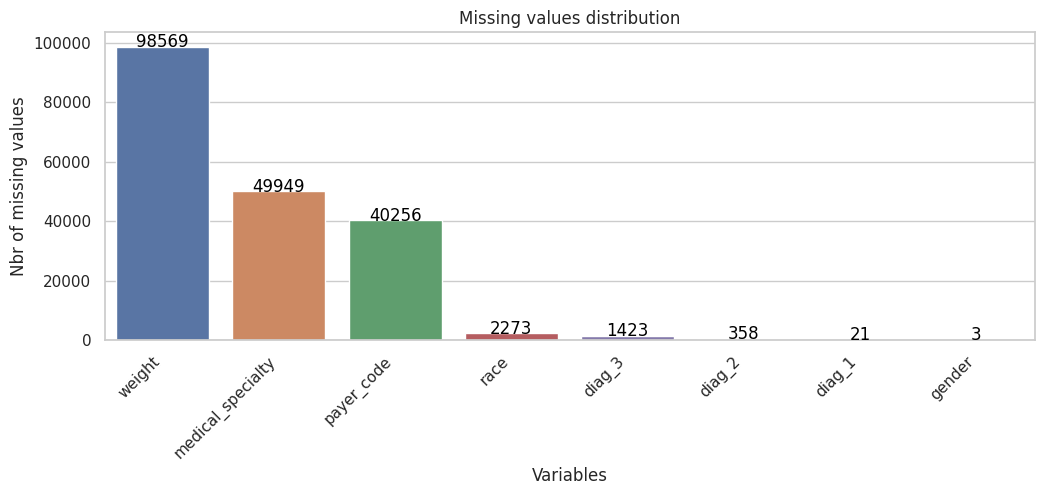

,Variables,total_missing_values,missing_values_rate(%),Nbr_of_unique_values
0,weight,98569,97.0,10
1,medical_specialty,49949,49.0,73
2,payer_code,40256,40.0,18
3,race,2273,2.0,6
4,diag_3,1423,1.0,790
5,diag_2,358,0.0,749
6,diag_1,21,0.0,717
7,gender,3,0.0,3


In [365]:

def bar_chart_plotter(df,x,y,title):
    # Set the style and palette
    sns.set(style="whitegrid")
    colors = sns.color_palette("deep")
    # Create the bar chart
    fig, ax = plt.subplots(figsize=(12, 4))
    sns.barplot(x=df[x], y=df[y], data=df, palette=colors)
    # Set the title and labels
    ax.set_title(title)
    ax.set_xlabel("Variables")
    ax.set_ylabel("Nbr of missing values")
    # Customize the x-axis labels
    plt.xticks(rotation=45, ha="right")
    # Add the values as labels above each bar
    for index, row in df.iterrows():
        ax.text(index, row[y] + 5, str(row[y]), color='black', ha="center")
    # Show the chart
    plt.show()

def pie_chart_plotter(df,x,y, title, labels = None,legend = None):  
    
    fig, ax = plt.subplots(figsize=(14, 6))
    
    num_colors = len(df[y])
    color_palette = sns.color_palette("deep", num_colors)
    colors = color_palette.as_hex()
    
    explode = [0.05]*len(df[y])
   
    ax.pie(df[y], colors=colors ,labels = labels,startangle=90, explode=explode, 
                                  labeldistance=1.1, radius=1)
   
    ax.set_title(title, fontsize=20, loc= 'left')
    
    ax.legend(legend, loc="best")
    # set text properties of labels
    #plt.setp(labels, fontsize=12, fontweight='bold', color='black', bbox=dict(facecolor='white', edgecolor='black'))
   
    # create a circle at the center of the pie
    centre_circle = plt.Circle((0,0),0.40,fc='white')
    fig.gca().add_artist(centre_circle)
    # set equal aspect ratio
    ax.axis('equal')
    # show the plot
    plt.show()



def visualize_missing_data(df):
    data_length = len(df)
    null_counts = df.isnull().sum()
    null_cols =null_counts[null_counts > 0]

    null_stats_df = pd.DataFrame(null_cols, columns=["total_missing_values"])
    null_stats_df[' missing_values_rate(%)'] = ((null_stats_df['total_missing_values'] / data_length ) * 100).round()

    nbr_uniquevals = [len(df[col].unique()) for col in null_cols.index.tolist()]
    uniquevals = [df[col].unique() for col in null_cols.index.tolist()]
    null_stats_df['Nbr_of_unique_values'] = nbr_uniquevals
   
    #pie chart

    null_stats_df = null_stats_df.sort_values(by='total_missing_values', ascending = False)

    null_stats_df.index.name = 'Variables'
    percents = null_stats_df[null_stats_df.columns[1]].astype(str) + '%'
    legend = null_stats_df.index + '  =  '+ percents 

    pie_chart_plotter(null_stats_df,null_stats_df.index,null_stats_df.columns[1],'Missing values Percentage',percents,legend)
   
    #bar chart 
    null_stats_df.reset_index(inplace=True)
    bar_chart_plotter(null_stats_df,null_stats_df.columns[0],null_stats_df.columns[1],'Missing values distribution')
    
    return null_stats_df

visualize_missing_data(raw_data)

- Variables race,gender,diag_1,diag_2,diag_3 have fairly low missing values compaired to others,so we decided to impute the missing values with the most common value.
- Variables gender, payer_code and medical_specialty have respectively 97%,40%,49% missing values so there is no usefulness in filling them, we decided to drop them.
 

In [366]:
# Impute columns with fairly low number of missing values with most common value 
columns_to_impute = ['race', 'gender','diag_1','diag_2','diag_3']
for col in columns_to_impute : 
    most_comon_value = raw_data[col].mode()[0]
    raw_data[col] = raw_data[col].fillna(most_comon_value)

# drop gender, payer_code and medical_specialty
raw_data = raw_data.drop(['weight','payer_code','medical_specialty'], axis = 1) 

## Data visualization


The objective of our analysis is to determine whether a patient will be readmitted to the hospital within a 30-day timeframe. The variable of interest encompasses three categories, namely, readmission within less than 30 days, readmission after more than 30 days, and no readmission. To facilitate binary classification, we have combined the categories of no readmission and readmission after more than 30 days into a single category, labeled as "0." The category of readmission within less than 30 days has been labeled as "1."

The target variable is imbalanced.we can observe a big gap between the readmitted patients and the ones not readmitted

### Variables/Features Distribution

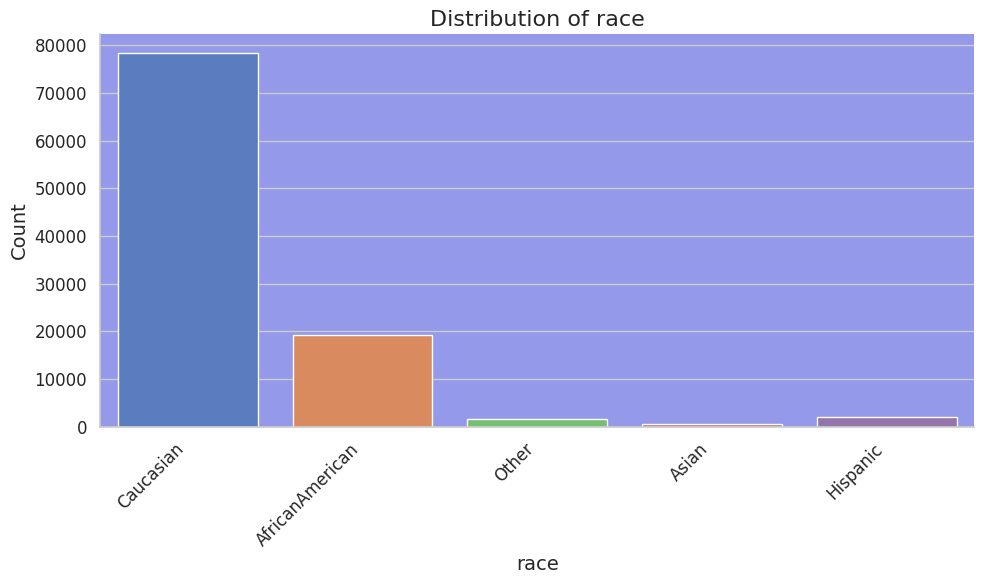

In [423]:

def plot_feature_distribution(feature):
    sns.set(style='whitegrid', rc={'axes.facecolor': '#9499e9','figure.facecolor': '#ffffff'})
    plt.figure(figsize=(10,6))
    sns.countplot(x=feature, data=raw_data, palette='muted')
    plt.xlabel(feature, fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.title('Distribution of '+ feature, fontsize=16)
    
    sns.despine()
    plt.tick_params(labelsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_feature_distribution('race')

####  Race

### Target Variable distribution

In [367]:
raw_data.readmitted = [1 if val =='<30' else 0 for val in raw_data.readmitted]

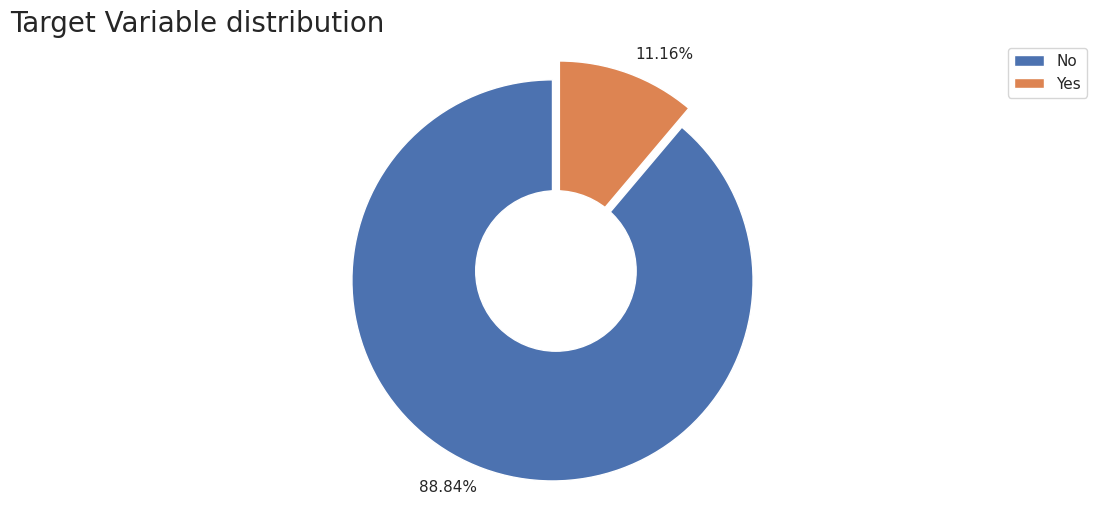

In [385]:
values = raw_data.readmitted.value_counts().tolist()
legend = ['No','Yes']
labels = [ str(round((value / len(raw_data) * 100),2))+'%' for value in values] 
df = pd.DataFrame({'Values' :values, 'labels' :labels })
pie_chart_plotter(df ,'labels', 'Values','Target Variable distribution',labels,legend)

#values = raw_data.gender.value_counts().tolist()
#legend = raw_data.gender.value_counts().index.tolist()
#labels = [ str(round((value / len(raw_data) * 100),2))+'%' for value in values] 
#df = pd.DataFrame({'Values' :values, 'labels' :labels })
#pie_chart_plotter(df ,'labels', 'Values','Gender Variable distribution',labels,legend)


### Influence of Various variables on the Target variable :

- Gender
- Race
- Age
- Insulin
- Changes in medication 
- Diabetes Medication 
- Glucose serum test results
- Number of lab procedures
- Number of medications used


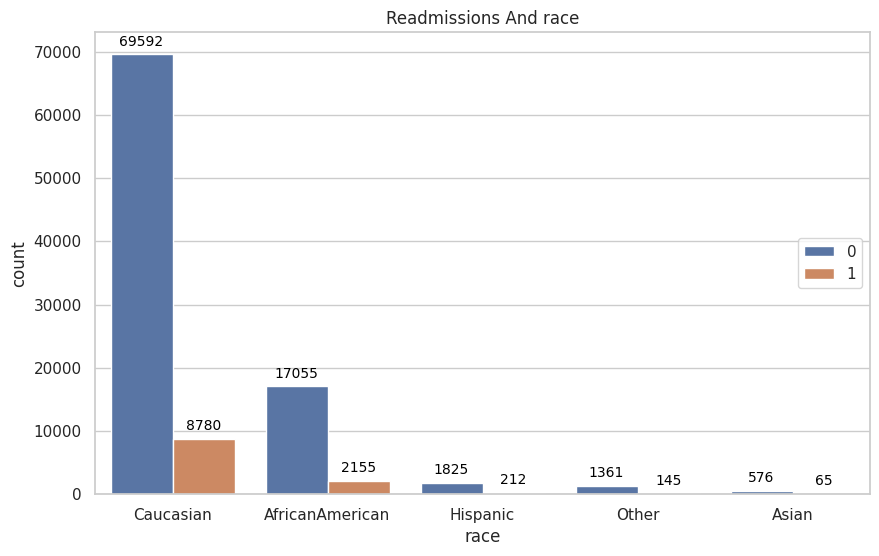

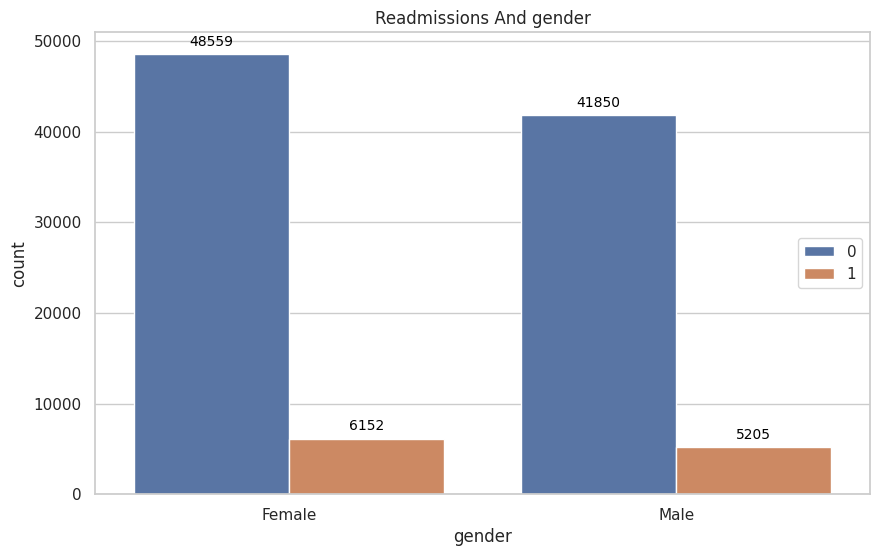

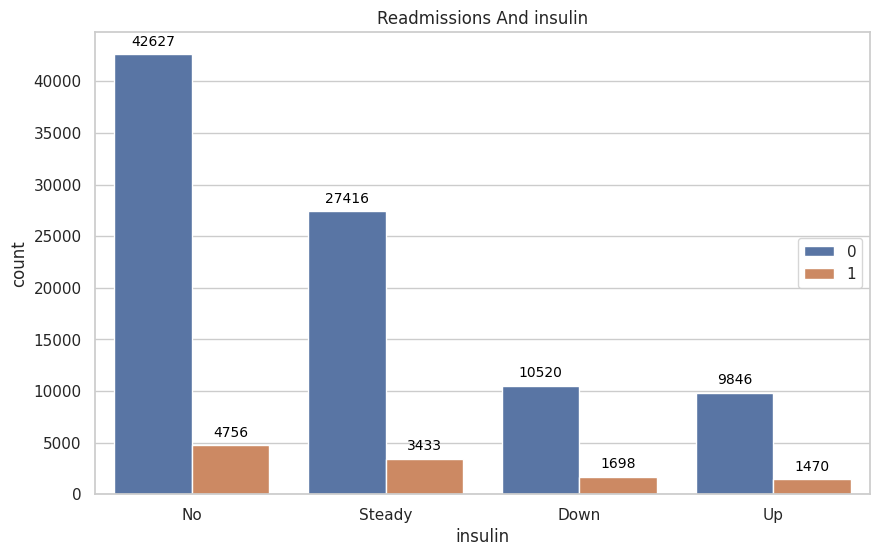

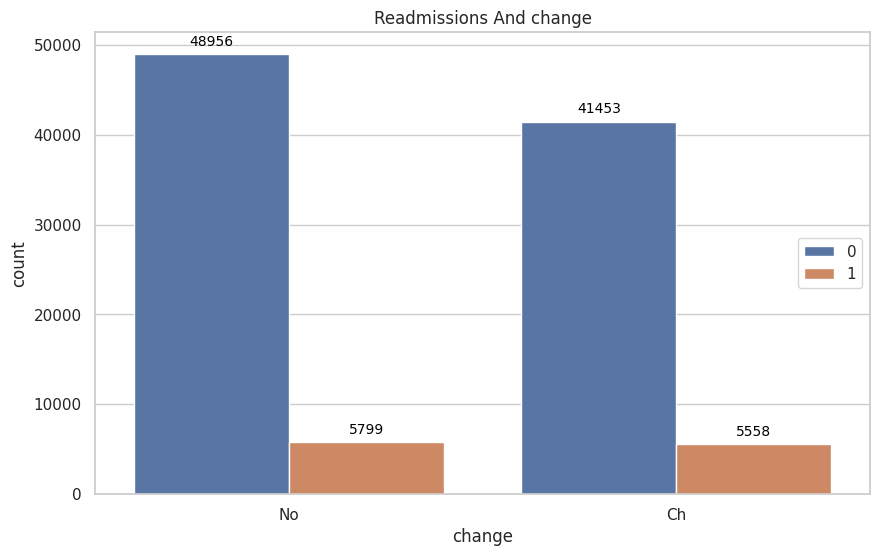

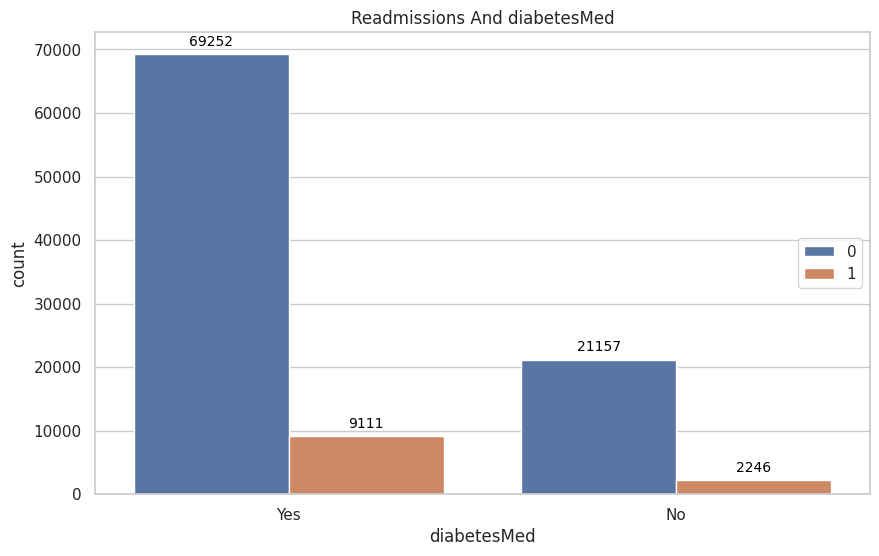

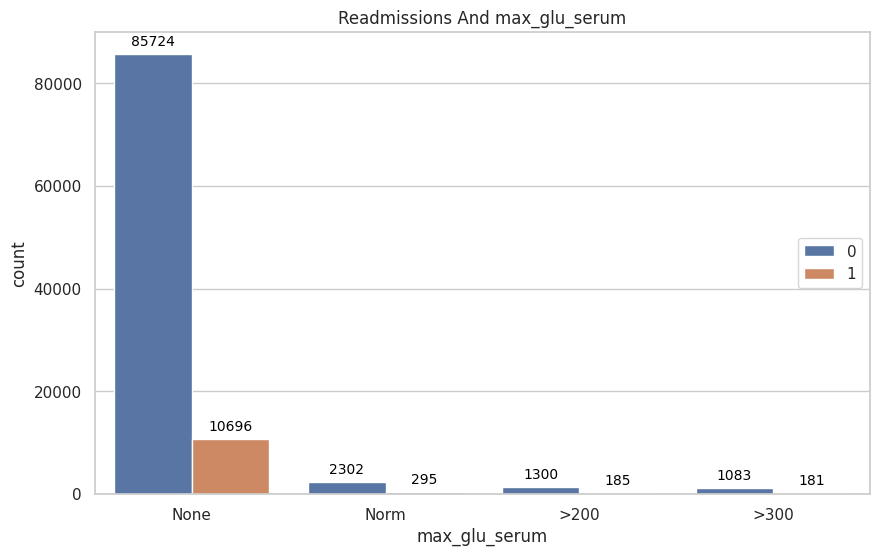

Text(0.5, 1.0, 'Readmission And Number of lab procedures')

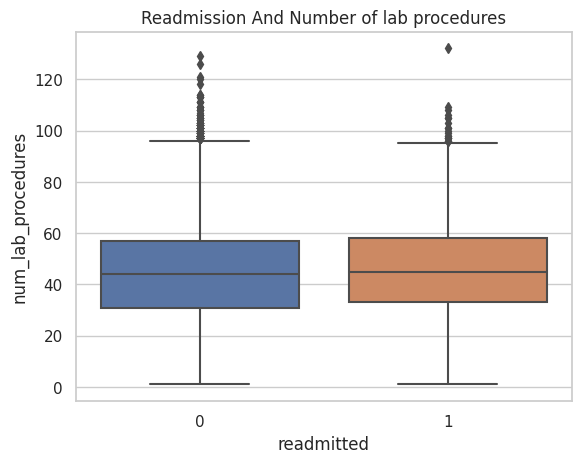

In [407]:
def plot_readmission_correlations(df,col):
    col_readmitted_group = raw_data.groupby([col,'readmitted']).readmitted.count()
    col_data = raw_data[col].unique().tolist()
    readmission = raw_data.readmitted.unique().tolist()
    
    readmitted = []
    for i in col_data:
        for j in readmission:
            if j == 1 :
                readmitted.append(col_readmitted_group[i][j])
            
    order = pd.DataFrame({'col': col_data, 'readmitted':readmitted}).sort_values(by='readmitted',ascending=False).col.tolist()
    
    #plot
    fig, ax =plt.subplots(figsize=(10,6))
    sns.countplot(x=col, hue="readmitted", data=raw_data, palette="deep" ,order = order)
    
    ax.set_title('Readmissions And '+ col)
    ax.legend(loc='right')

    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.0f}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 4),
                    textcoords='offset points')
    plt.show()
     
    
plot_readmission_correlations(raw_data,"race")
plot_readmission_correlations(raw_data,"gender")
plot_readmission_correlations(raw_data,"insulin")
plot_readmission_correlations(raw_data,"change")
plot_readmission_correlations(raw_data,"diabetesMed")
plot_readmission_correlations(raw_data,"max_glu_serum")
sns.boxplot(x="readmitted", y="num_lab_procedures", data=raw_data).set_title('Readmission And Number of lab procedures')
